In [1]:
# import all packages

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

from keras import regularizers
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/t

In [2]:
### original dataset visualization

def show_orgi_data(dataset_name):
    
    # load data
    data = pd.read_csv(dataset_name, header=0, parse_dates=[0], index_col=0, squeeze=True)
    
    # show original data
    groups = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    i = 1
    # plot each column
    plt.figure(figsize=(15,20))
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(data.values[:, group])
        plt.title(data.columns[group], y=0.5, loc='right')
        i += 1
    plt.tight_layout()
    data.info()
    
    return data

In [3]:
### data pre-processing

def pre_processing(data):
    # check nonnull
    data = data.fillna(data.mean())
    
    # split the data to end up with the following dataframes: X_train,X_test,y_train, y_test   
    X = data.drop(columns=['date','NO2-2020','COVID-19 increased cases','COVID-19 increased deaths','Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'])
    y = data['NO2-2020']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=42)
    
    # standardscaler
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    X_train_scaled = xscaler.fit_transform(X_train)
    X_test_scaled = xscaler.transform(X_test)
    y_train_scaled = yscaler.fit_transform(y_train.values.reshape(-1,1))
    y_test_scaled = yscaler.transform(y_test.values.reshape(-1,1))
    
    # perform a boxplot of X_train_scaled here
    ax = sns.boxplot(data=X_train)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
    ax.set_title("original data distribution")
    plt.show()
    
    ax = sns.boxplot(data=X_train_scaled)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
    ax.set_title("pre_processing data distribution")
    plt.show()
   
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, yscaler

In [4]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title=plttitle)
    ax.set(ylabel=metric[0].swapcase() + metric[1:])
    ax.set(xlabel='Epoch')
    ax.legend(['train', 'val'], loc='upper right')

In [5]:
### plot learning curve
def plot_learning_curves(model, X_train, X_test, y_train, y_test):    
    train_errors, test_errors = [], []
    for m in range(10, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown
    plt.show()

In [6]:
### plot observed data and predicted data
def plot_residual(model, X_train, X_test, y_train, y_test, yscaler):
    
    #get_ipython().run_line_magic('matplotlib', 'inline')
    
#     st.markdown("## Observed Data and Predicted Data")
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
    print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
    print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
    print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

    y_test = yscaler.inverse_transform(y_test)
    y_pred_test = yscaler.inverse_transform(y_pred_test)
    
    minlim = y_test.min()
    maxlim = y_test.max()
    # predicted/actual plot for test set
    ax = sns.jointplot(x=y_test,y=y_pred_test, height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
    ax.ax_joint.set_xlabel('observed NO2 reduction')
    ax.ax_joint.set_ylabel('predicted NO2 reduction')
#     st.pyplot()
    plt.figure()
    sns.distplot(y_test-y_pred_test)
    plt.xlabel('Residuals')
    plt.show()
#     st.pyplot()

In [7]:
def plot_residual_svm(model, X_train, X_test, y_train, y_test, yscaler):
    
    #get_ipython().run_line_magic('matplotlib', 'inline')
    
#     st.markdown("## Observed Data and Predicted Data")
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
    print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
    print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
    print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))
    
    minlim = y_test.min()
    maxlim = y_test.max()
    # predicted/actual plot for test set
    ax = sns.jointplot(x=y_test,y=y_pred_test, height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
    ax.ax_joint.set_xlabel('observed NO2 reduction')
    ax.ax_joint.set_ylabel('predicted NO2 reduction')
#     st.pyplot()
    plt.figure()
    sns.distplot(y_test-y_pred_test)
    plt.xlabel('Residuals')
    plt.show()

In [8]:
### plot observed data and predicted data for NNs model
def plot_residual_nns(model, X_train, X_test, y_train, y_test, yscaler):
    y_pred_train = np.concatenate(model.predict(X_train).astype('float'))
    y_pred_test = np.concatenate(model.predict(X_test).astype('float'))

    print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
    print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
    print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
    print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

    y_test = yscaler.inverse_transform(y_test)
    y_pred_test = yscaler.inverse_transform(y_pred_test)
    minlim = y_test.min()
    maxlim = y_test.max()
    # predicted/actual plot for test set
    ax = sns.jointplot(x=y_test.reshape(-1,1),y=y_pred_test.reshape(-1,1), height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
    ax.ax_joint.set_xlabel('observed NO2 reduction')
    ax.ax_joint.set_ylabel('predicted NO2 reduction')
    plt.figure()
    sns.distplot(y_test-y_pred_test)
    plt.xlabel('Residuals')
    plt.show()

In [9]:
### Model 1: Decision Trees
def dt_model(X_train, X_test, y_train, y_test):

    sc = StandardScaler()
    dtr = DecisionTreeRegressor(splitter='best',random_state=42,max_depth=12,min_samples_split=6,max_features=1,criterion='mse')
    pipe = Pipeline([('scaler',sc),('tree', dtr)])
    model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())   
    model.fit(X_train, y_train)
    return model



In [10]:
### Model 2: random forests

def rf_model(X_train, X_test, y_train, y_test):
    sc = StandardScaler()
    rfr = RandomForestRegressor(n_estimators=1000,max_features=1,min_samples_split=6)
    pipe = Pipeline([('scaler',sc),('forest', rfr)])
    model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
    model.fit(X_train, y_train)
    return model


In [11]:
### Model 3: adaboost
def ab_model(X_train, X_test, y_train, y_test):  
    sc = StandardScaler()
    dtr = DecisionTreeRegressor(splitter='best',random_state=42,max_features=1,min_samples_split=6,max_depth=5)
    pipe = AdaBoostRegressor(base_estimator = dtr,n_estimators=100,loss='exponential')
    model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
    model.fit(X_train, y_train)
    return model


In [12]:
### Model 4: gbt
def gbt_model(X_train, X_test, y_train, y_test):

    sc = StandardScaler()
    gbt = GradientBoostingRegressor(n_estimators=50,max_features=2,min_samples_split=5)
    pipe = Pipeline([('scaler',sc),('gbt', gbt)])
    model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
    model.fit(X_train, y_train)
    return model


In [13]:
### Model 5: SVM
def svm_model(X_train, X_test, y_train, y_test):

    svm_poly_reg = SVR(kernel="poly", degree=3, C=0.1, epsilon=2, gamma= 0.5,coef0=1)

    svm_poly_reg.fit(X_train, y_train)

    return svm_poly_reg

In [14]:
### Model 6: KNN
def knn_model(X_train, X_test, y_train, y_test):
    neigh = KNeighborsRegressor(n_neighbors=5)
    neigh.fit(X_train, y_train)
    return neigh

   

In [15]:
### Model 7: GPR
def gp_model(X_train, X_test, y_train, y_test):
    kernel = DotProduct() + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=kernel,
       random_state=42).fit(X_train, y_train)
    return gpr


In [16]:
### Model 8: NNs
def nns_model(X_train, X_test, y_train, y_test, epochs = 20, batch_size = 256):

    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=X_train.shape[1:]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation="linear", name="output"))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.MeanSquaredError()])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
    history_nns = model.fit(X_train, y_train, validation_split=0.25, epochs=epochs, callbacks=[es], verbose=0)

    plot_model_history(history_nns, plttitle='NNs')
    return model

In [17]:
### complete pipeline

def main(dataset_name,model_name):
    ### Pipeline: 1. show original data
    data = show_orgi_data(dataset_name)
    
    ### Pipeline: 2. data pre-processing
    X_train, X_test, y_train, y_test, yscaler = pre_processing(data)
    

    ### Pipeline: 3. model selection
    if model_name == 'Decision Tree':
#         st.markdown("# Pipeline: 3. Choose model 'Decision Tree' ")
        model = dt_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'Random Forests':
#         st.markdown("# Pipeline: 3. Choose model 'Random Forests' ")
        model = rf_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'Adaboost':
#         st.markdown("# Pipeline: 3. Choose model 'Adaboost' ")
        model = ab_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'GBDT':
#         st.markdown("# Pipeline: 3. Choose model 'GBDT' ")
        model = gbt_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'SVM':
#         st.markdown("# Pipeline: 3. Choose model 'SVR' ")
        y_train = y_train[:,0]
        y_test = y_test[:,0]
        y_train = yscaler.inverse_transform(y_train)
        y_test = yscaler.inverse_transform(y_test)
        model = svm_model(X_train, X_test, y_train, y_test)
        plot_residual_svm(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'Gaussian Process':
#         st.markdown("# Pipeline: 3. Choose model 'Gaussian Process' ")
        model = gp_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'KNN':
#         st.markdown("# Pipeline: 3. Choose model 'KNN' ")
        model = knn_model(X_train, X_test, y_train, y_test)
        plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    elif model_name == 'Neural Network':
#         st.markdown("# Pipeline: 3. Choose model 'Neural Network' ")
        model = nns_model(X_train, X_test, y_train, y_test)
        plot_residual_nns(model, X_train, X_test, y_train, y_test, yscaler)
    


<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

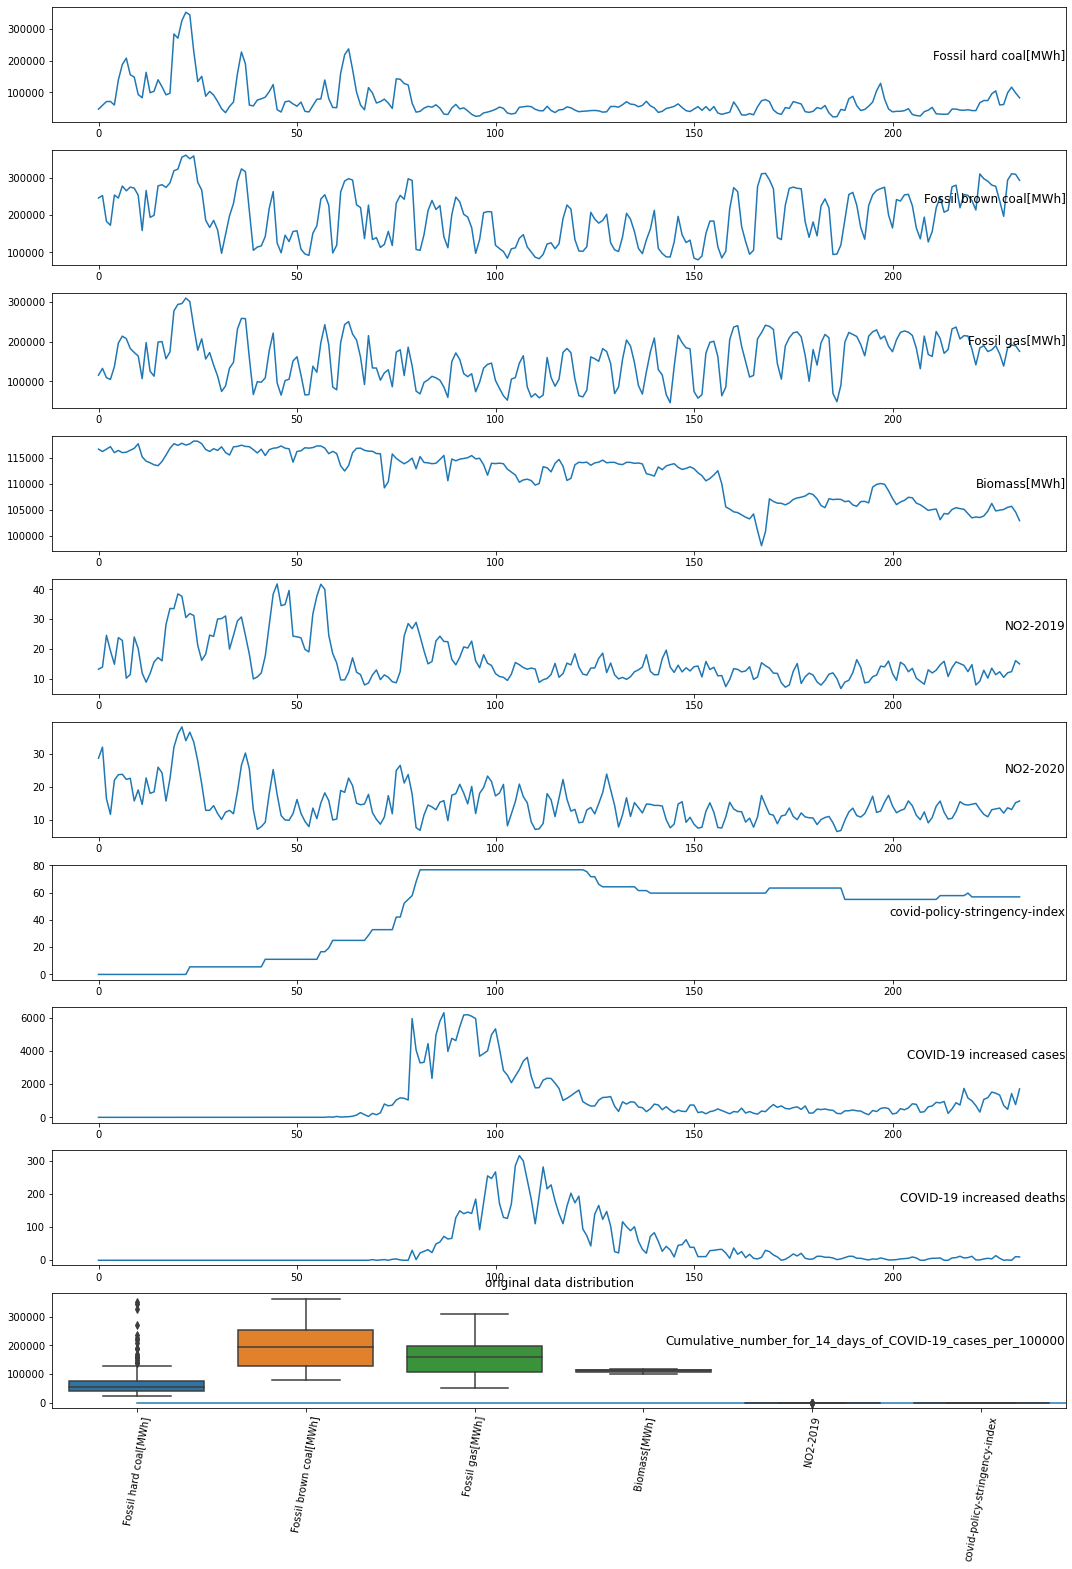

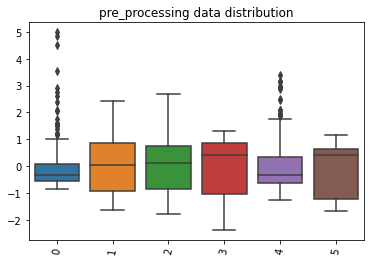

RMSE training fit: 0.314
R2 training fit: 0.901 
RMSE prediction: 0.641
R2 prediction: 0.577 


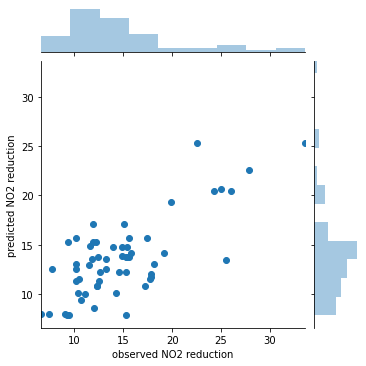

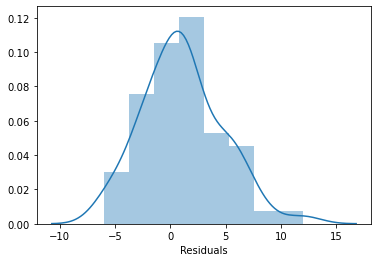

In [18]:
dataset_name = 'AMI_Data.csv'
model_name = 'Decision Tree'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

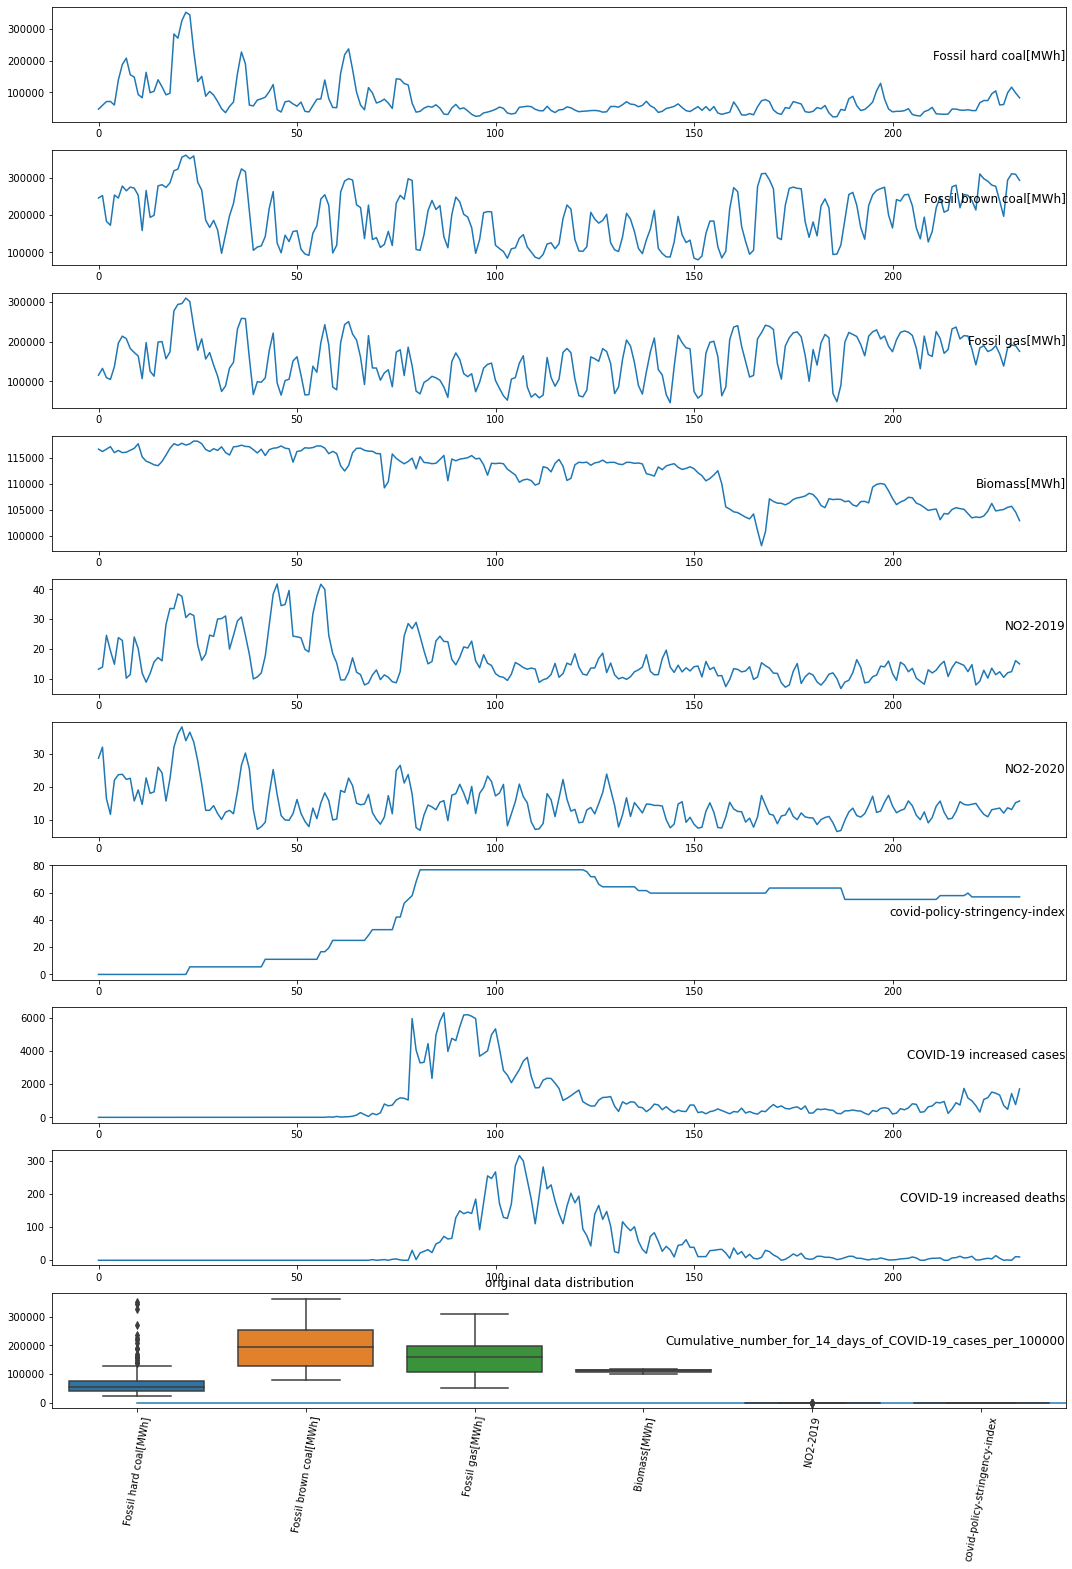

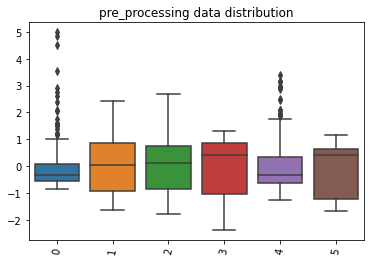

RMSE training fit: 0.332
R2 training fit: 0.890 
RMSE prediction: 0.533
R2 prediction: 0.707 


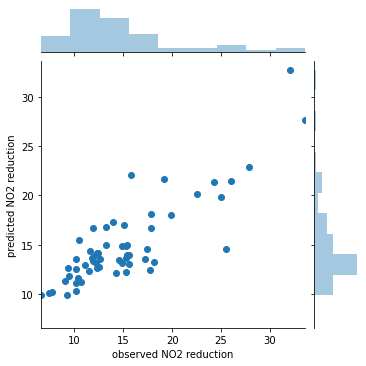

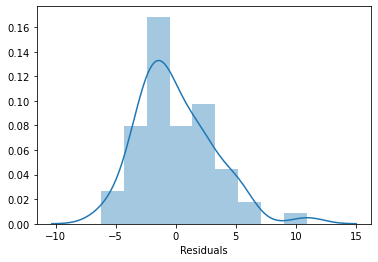

In [19]:
dataset_name = 'AMI_Data.csv'
model_name = 'Random Forests'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

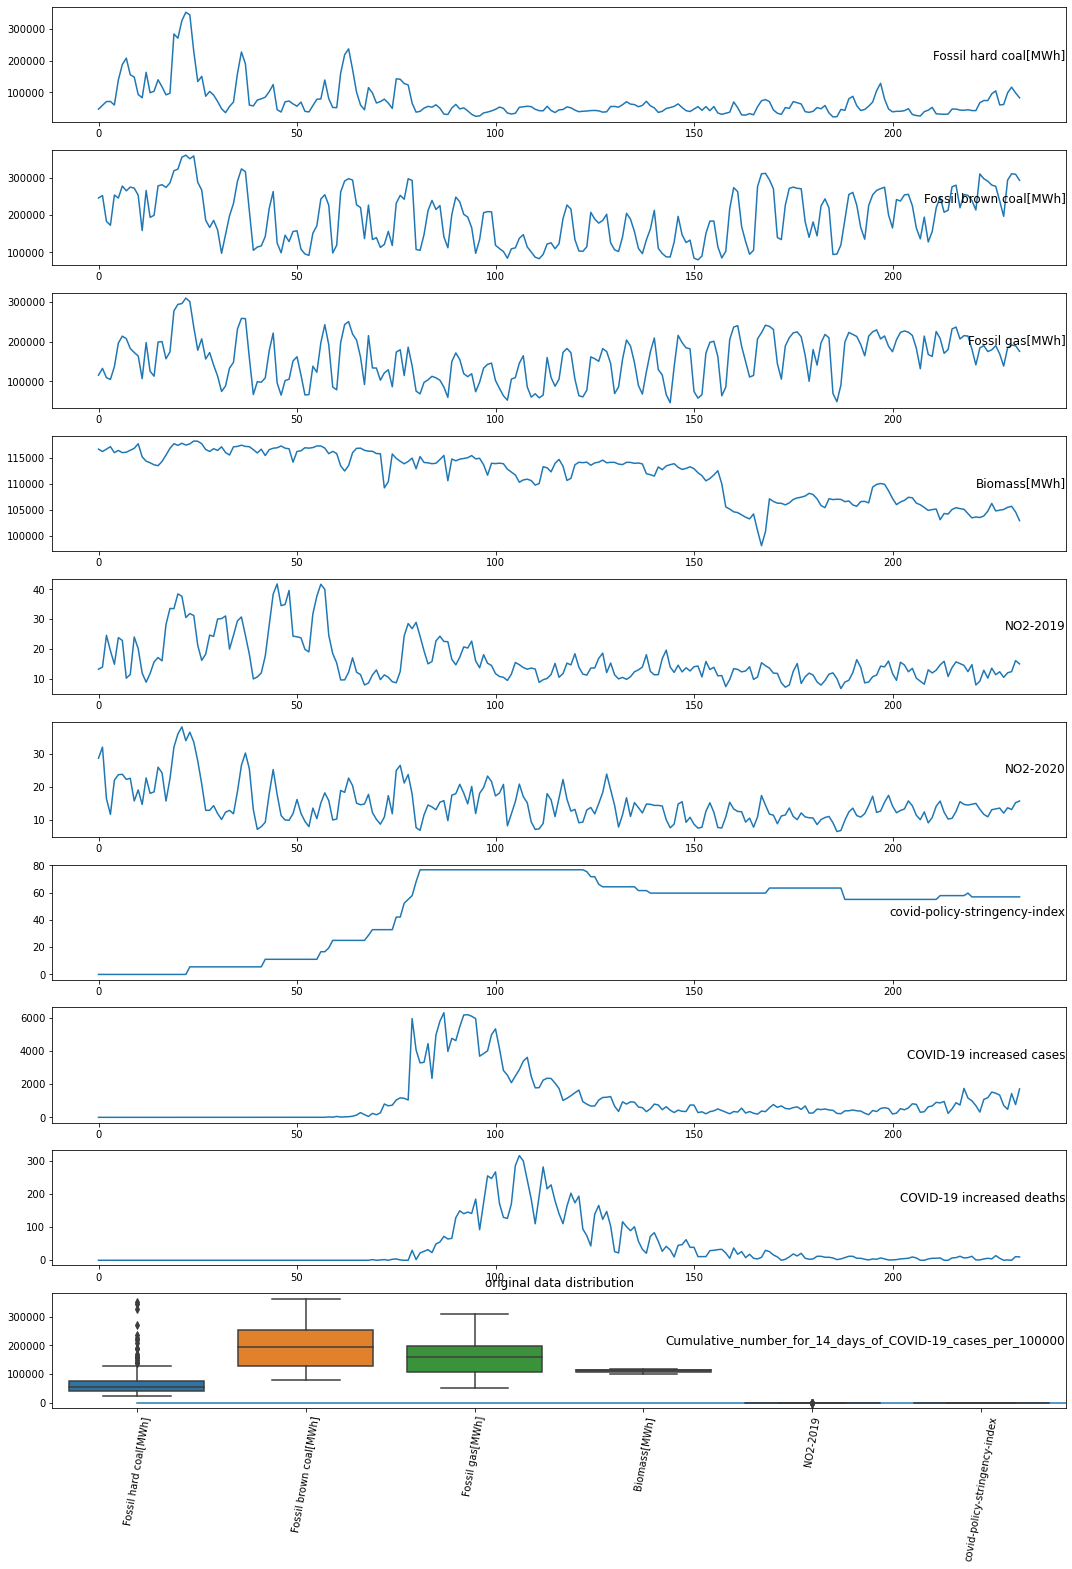

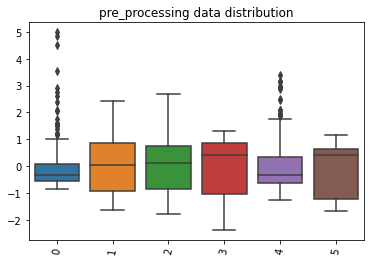

RMSE training fit: 0.308
R2 training fit: 0.905 
RMSE prediction: 0.549
R2 prediction: 0.690 


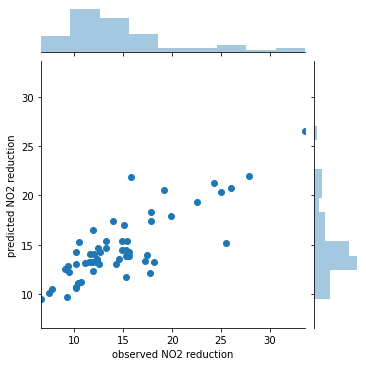

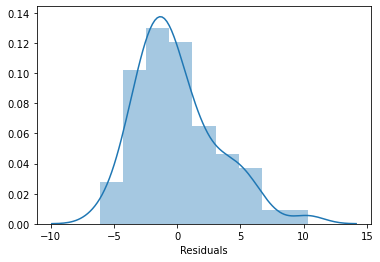

In [20]:
dataset_name = 'AMI_Data.csv'
model_name = 'Adaboost'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

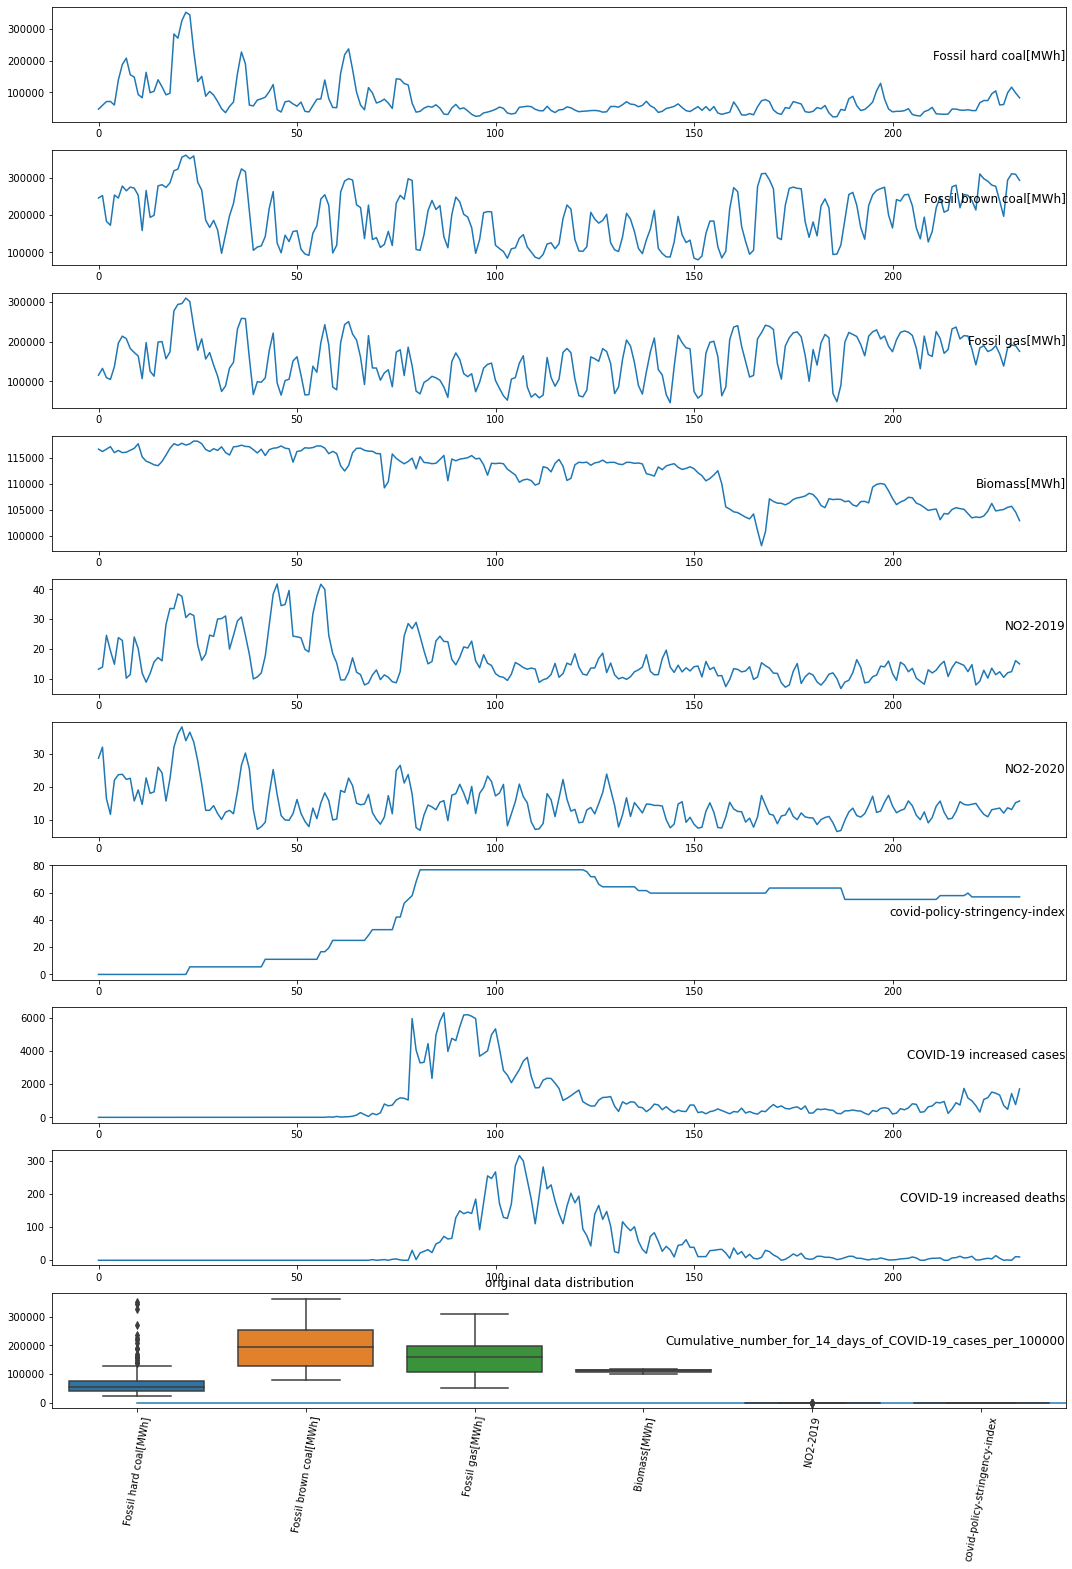

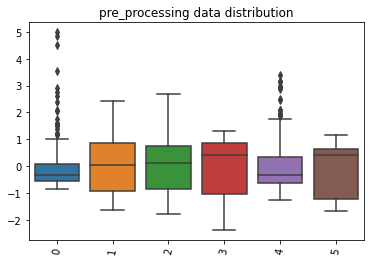

RMSE training fit: 0.305
R2 training fit: 0.907 
RMSE prediction: 0.552
R2 prediction: 0.687 


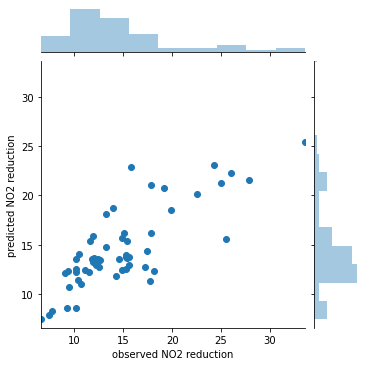

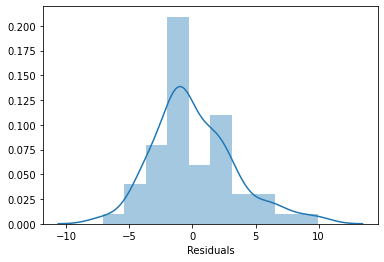

In [21]:
dataset_name = 'AMI_Data.csv'
model_name = 'GBDT'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

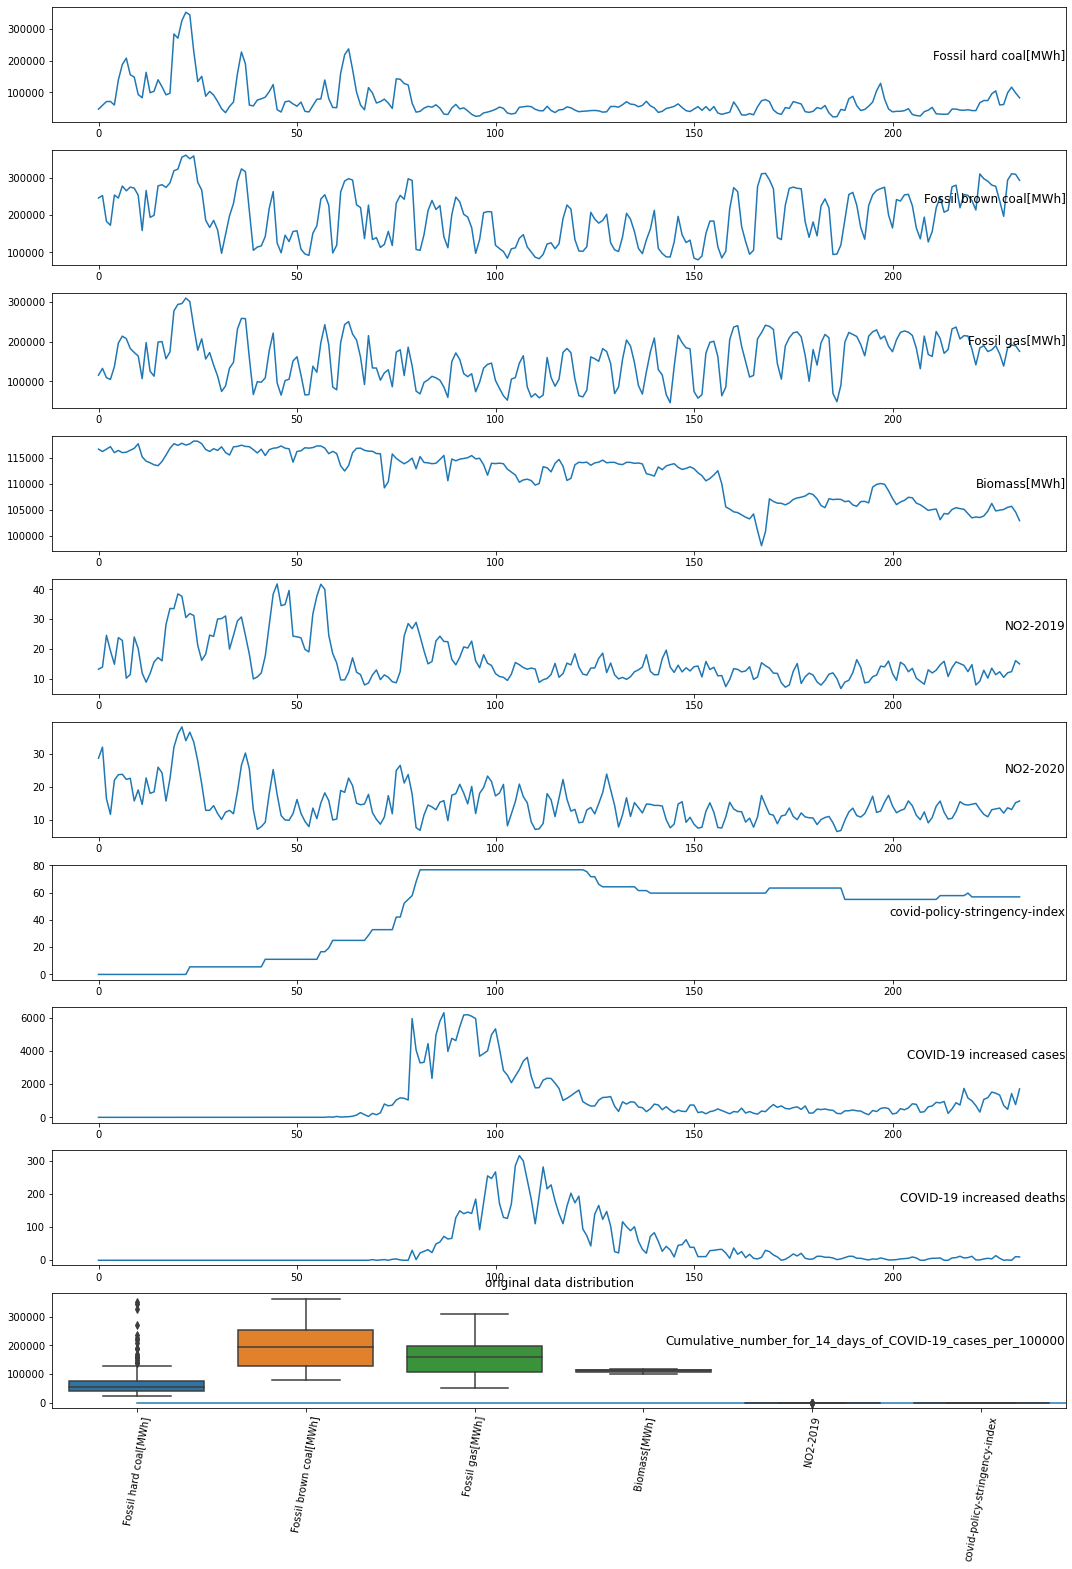

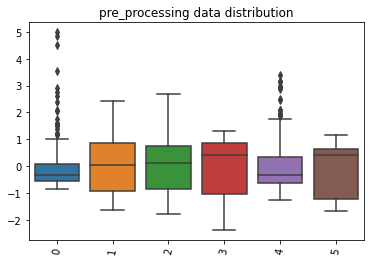

RMSE training fit: 0.481
R2 training fit: 0.768 
RMSE prediction: 0.556
R2 prediction: 0.682 


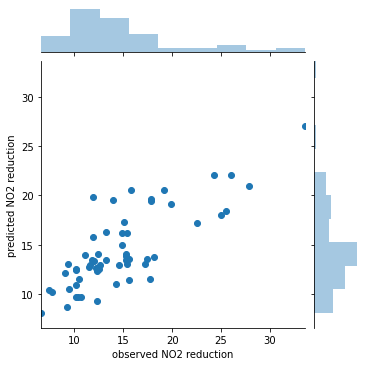

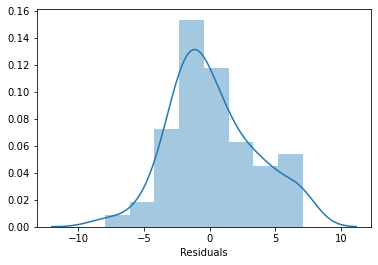

In [22]:
dataset_name = 'AMI_Data.csv'
model_name = 'KNN'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

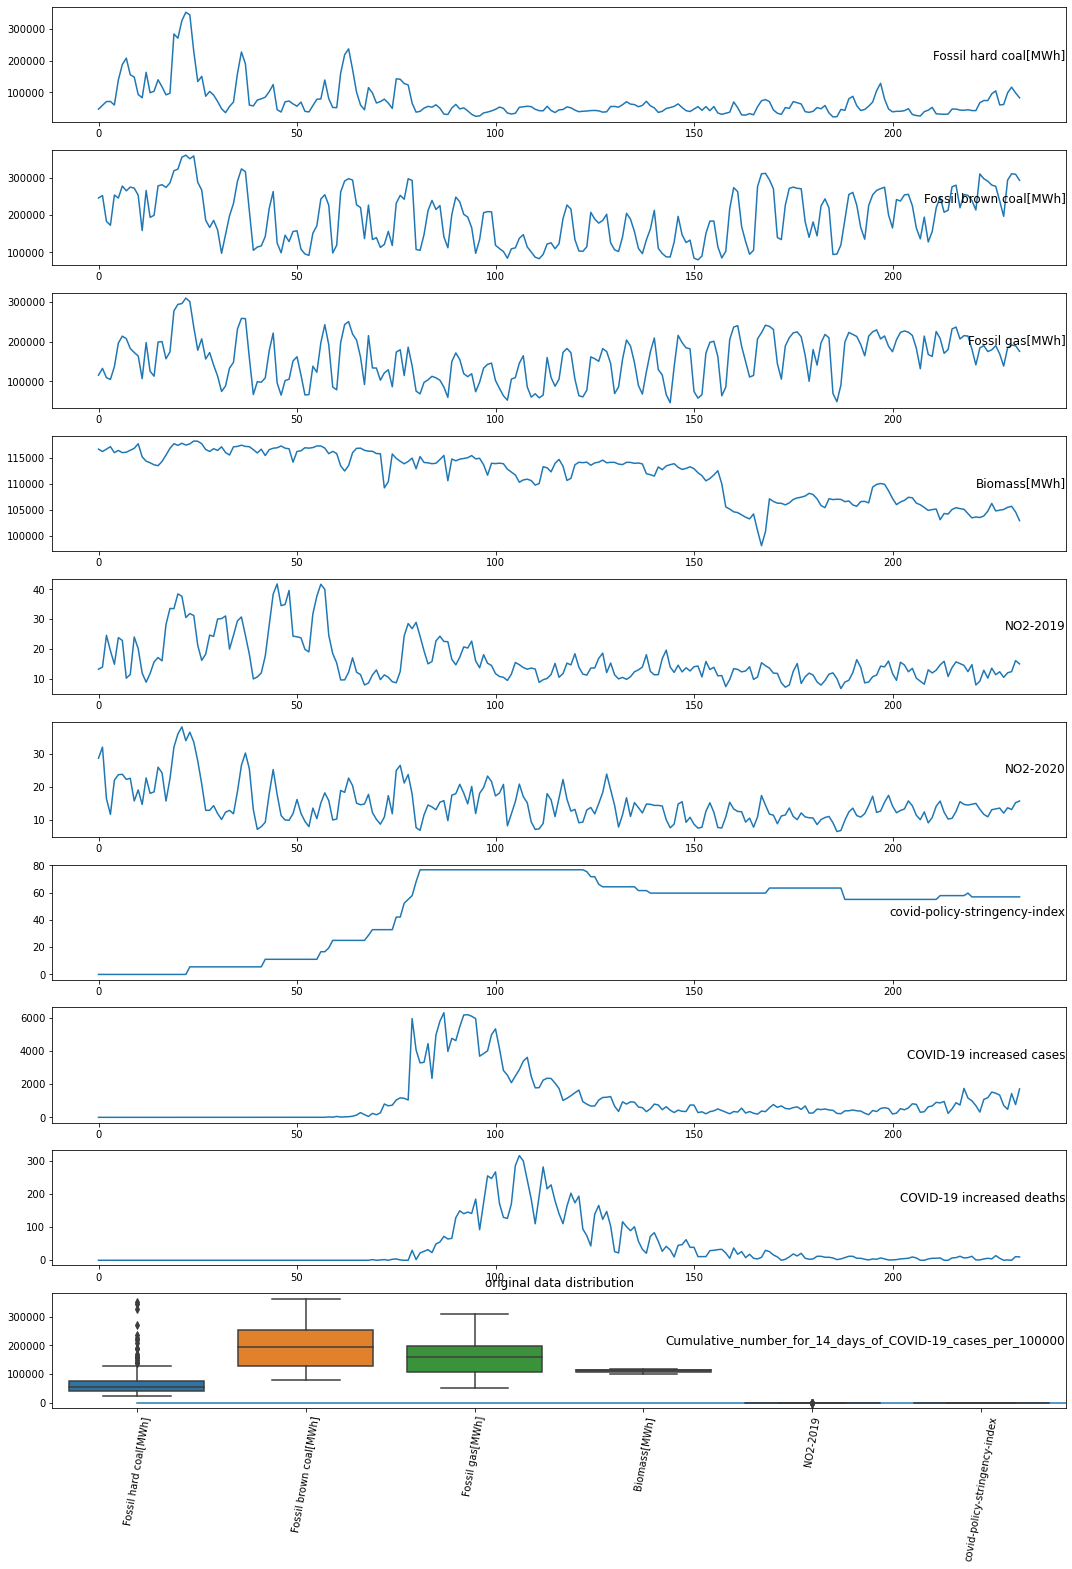

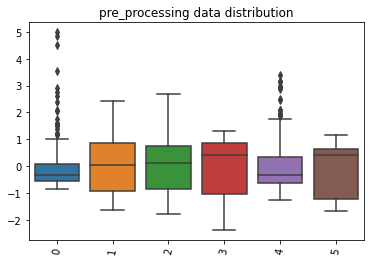

RMSE training fit: 2.833
R2 training fit: 0.765 
RMSE prediction: 3.034
R2 prediction: 0.723 


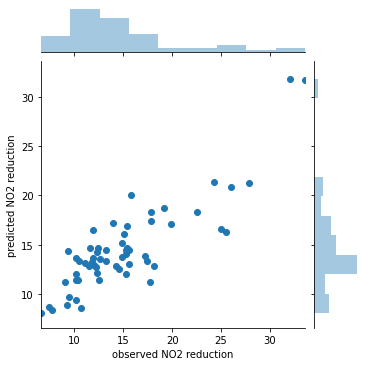

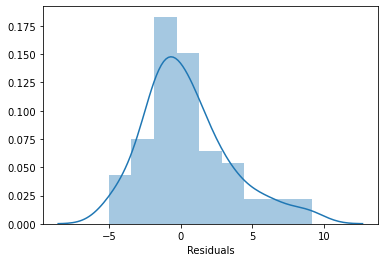

In [23]:
dataset_name = 'AMI_Data.csv'
model_name = 'SVM'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

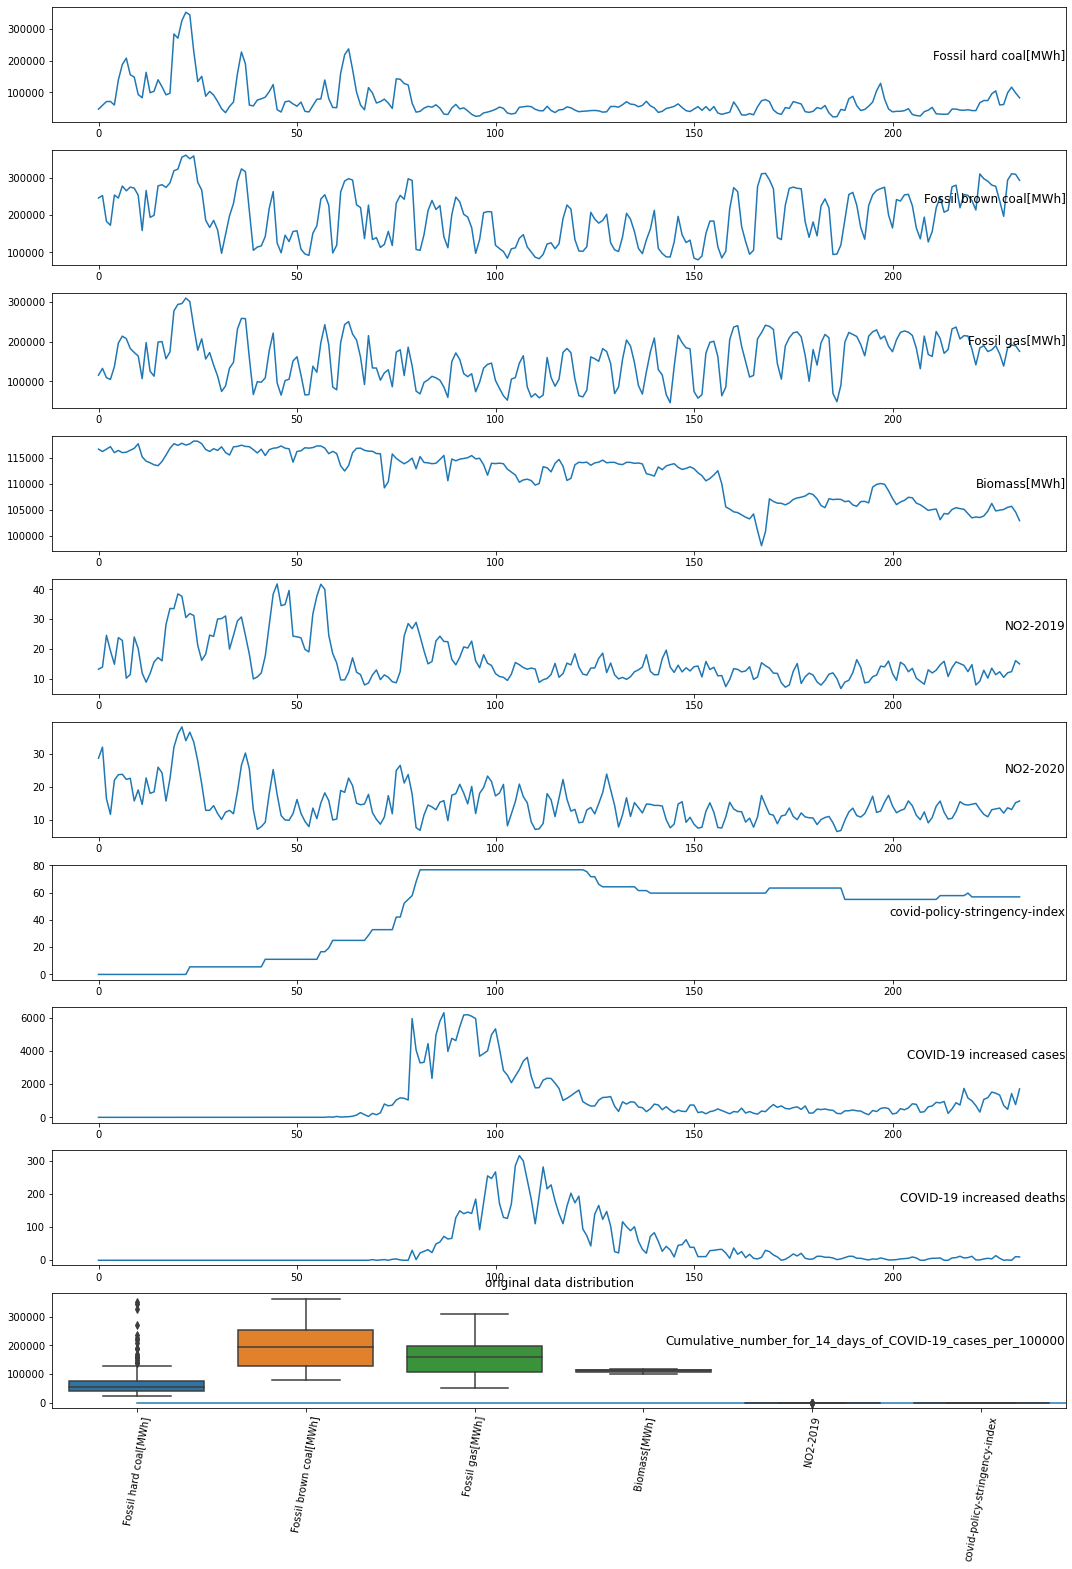

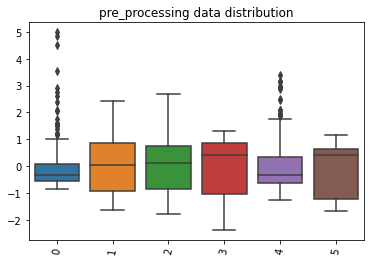


RMSE training fit: 0.500
R2 training fit: 0.750 
RMSE prediction: 0.535
R2 prediction: 0.706 


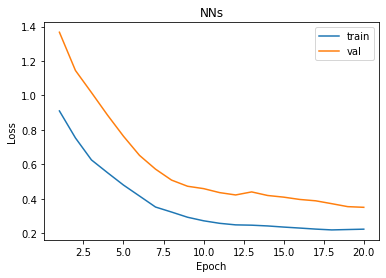

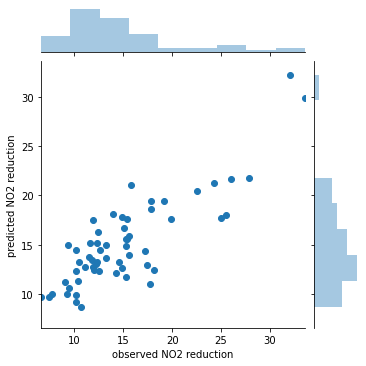

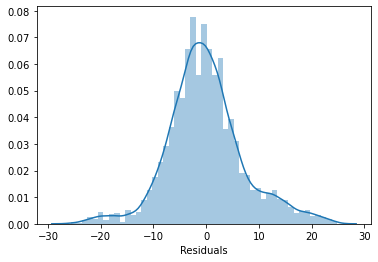

In [24]:
dataset_name = 'AMI_Data.csv'
model_name = 'Neural Network'
main(dataset_name,model_name)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   date                                                        233 non-null    object 
 1   Fossil hard coal[MWh]                                       233 non-null    int64  
 2   Fossil brown coal[MWh]                                      233 non-null    int64  
 3   Fossil gas[MWh]                                             233 non-null    int64  
 4   Biomass[MWh]                                                233 non-null    int64  
 5   NO2-2019                                                    233 non-null    float64
 6   NO2-2020                                                    233 non-null    float64
 7   covid-policy-stringency-index                               233 non-null    float64
 8   

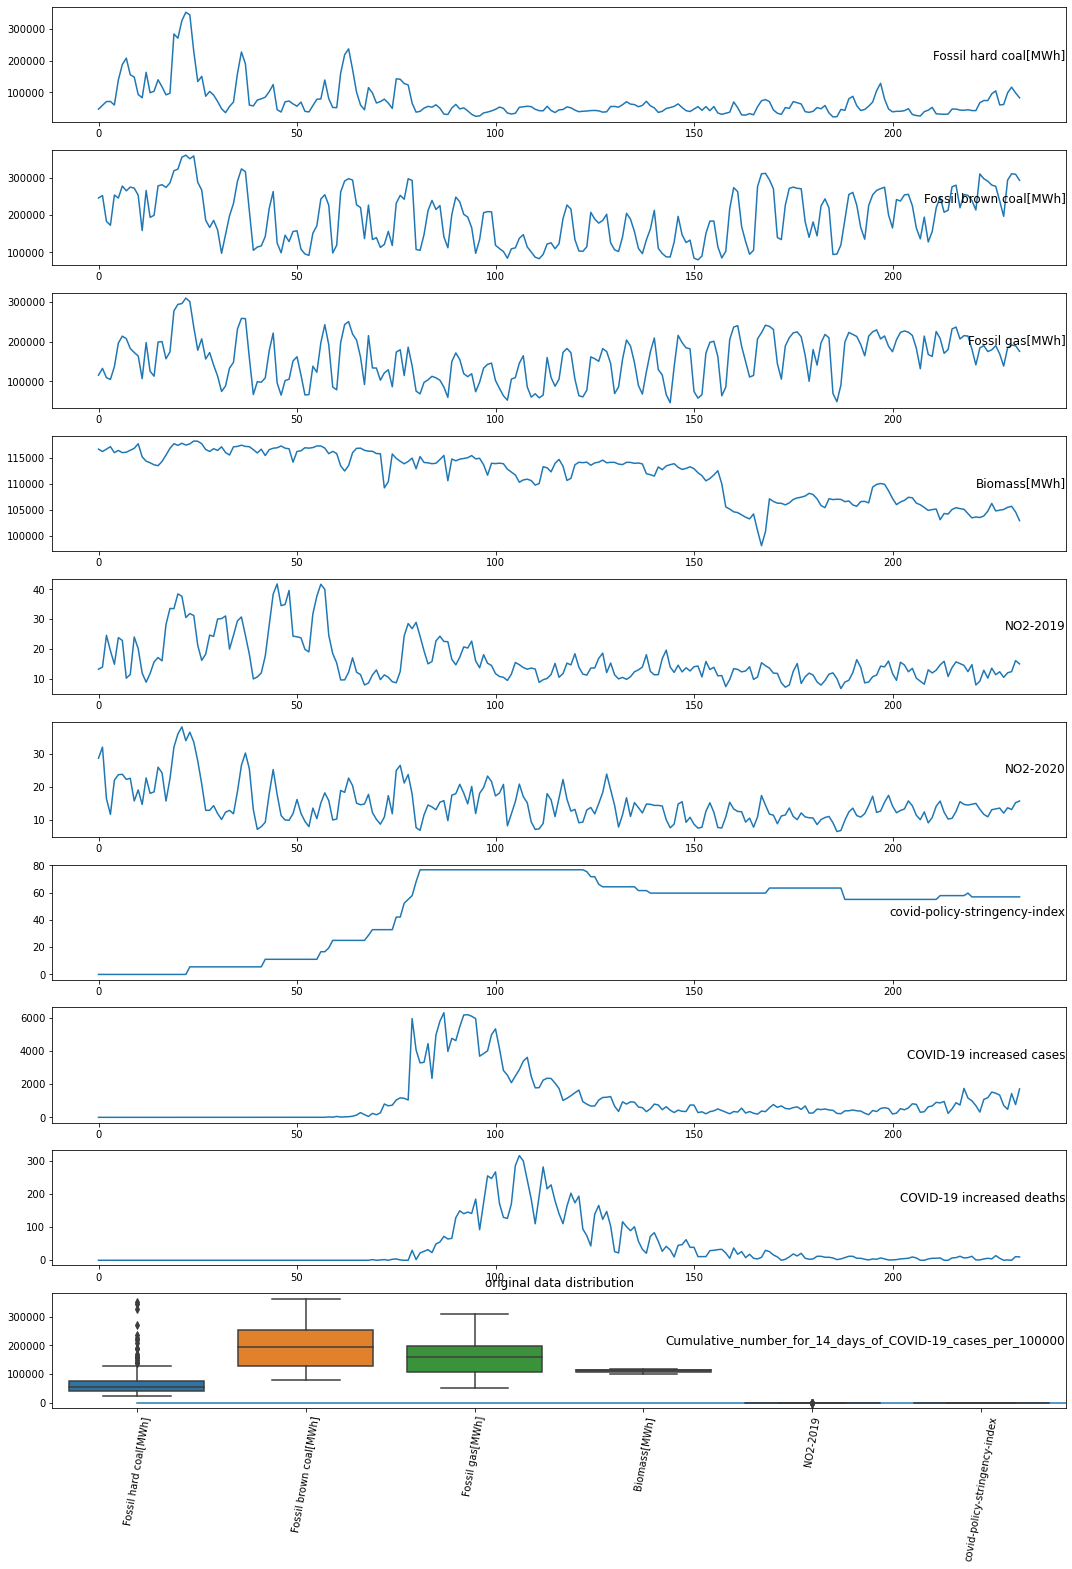

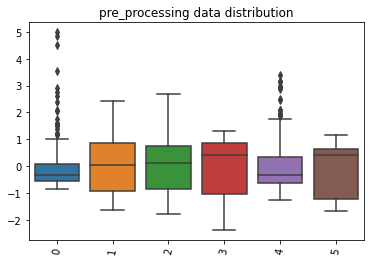

RMSE training fit: 0.605
R2 training fit: 0.634 
RMSE prediction: 0.609
R2 prediction: 0.618 


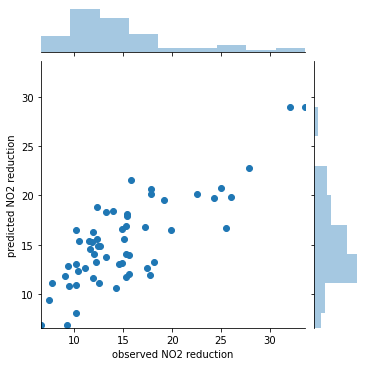

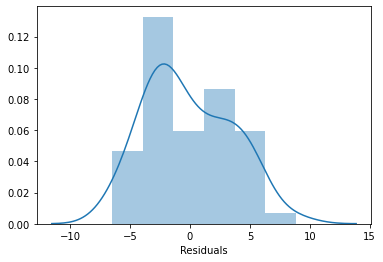

In [25]:
dataset_name = 'AMI_Data.csv'
model_name = 'Gaussian Process'
main(dataset_name,model_name)